In [1]:
! git clone https://github.com/Duckkyy/3rd_year_experiment.git

Cloning into '3rd_year_experiment'...
remote: Enumerating objects: 37004, done.
remote: Counting objects: 100% (2108/2108), done.
remote: Compressing objects: 100% (2074/2074), done.
remote: Total 37004 (delta 31), reused 2108 (delta 31), pack-reused 34896
Receiving objects: 100% (37004/37004), 913.37 MiB | 17.22 MiB/s, done.
Resolving deltas: 100% (14075/14075), done.
Checking out files: 100% (38754/38754), done.


In [2]:
!python3 "/content/drive/My Drive/app/mnist_cnn.py"


python3: can't open file '/content/drive/My Drive/app/mnist_cnn.py': [Errno 2] No such file or directory


In [3]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [4]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [5]:
from __future__ import print_function, division
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
plt.ion()


# New Section

In [6]:
# transforming_hymen_data = {
#     'train': transforms.Compose([
#         transforms.RandomResizedCrop(224),
#         transforms.RandomHorizontalFlip(),
#         transforms.ToTensor(),
#         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
#     ])
# }
# data_dir = '3rd_year_experiment/emotions/data'
# datasets_images = {'train': datasets.ImageFolder(os.path.join(data_dir, 'train'),  transforming_hymen_data['train'])}
# loaders_data = {'train': torch.utils.data.DataLoader(datasets_images['train'], batch_size=4,
#                                              shuffle=True, num_workers=1)}
# sizes_datasets = {'train': len(datasets_images['train'])}

transforming_hymen_data = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '3rd_year_experiment/emotions/data'
datasets_images = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          transforming_hymen_data[x])
                  for x in ['train', 'val']}
loaders_data = {x: torch.utils.data.DataLoader(datasets_images[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
sizes_datasets = {x: len(datasets_images[x]) for x in ['train', 'val']}
class_names = datasets_images['train'].classes

In [7]:
class_names = datasets_images['train'].classes
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [8]:
print(class_names)
print(device)

['1', '2', '3', '4', '5', '6', '7']
cuda:0


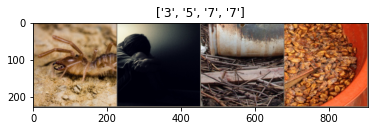

In [9]:
def visualize_data(input, title=None):
    input = input.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    input = std * input + mean
    input = np.clip(input, 0, 1)
    plt.imshow(input)
    if title is not None:
       plt.title(title)
    plt.pause(0.001)  ## Here we are pausing a bit so that plots are updated


inputs_data, classes = next(iter(loaders_data['train']))
## This is the code for getting a batch of training data

out = torchvision.utils.make_grid(inputs_data)
## Here we are making a grid from batch

visualize_data(out, title=[class_names[x] for x in classes])

In [10]:
def train(res_model, criterion, optimizer, scheduler, number_epochs=25):

    since = time.time()

    best_resmodel_wts = copy.deepcopy(res_model.state_dict())
    best_accuracy = 0.0

    for epochs in range(number_epochs):
        print('Epoch {}/{}'.format(epochs, number_epochs - 1))
        print('-' * 10)
        for phase in ['train', 'val']: ## Here each epoch is having a training and validation phase
            res_model.train()
            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in loaders_data[phase]: ## Iterating over data.
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad() ## here we are making the gradients to zero

                with torch.set_grad_enabled(phase == 'train'): ## forwarding and then tracking the history if only in train
                     outputs = res_model(inputs)
                     _, preds = torch.max(outputs, 1)
                     loss = criterion(outputs, labels)

                     if phase == 'train': # backward and then optimizing only if it is in training phase
                         loss.backward()
                         optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / sizes_datasets[phase]
            epoch_acc = running_corrects.double() / sizes_datasets[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_accuracy))

    # load best model weights
    res_model.load_state_dict(best_resmodel_wts)
    return res_model



In [11]:
def model_visualization(res_model, num_images=6):

    was_training = res_model.training
    res_model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(loaders_data['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = res_model(inputs)
            _, preds = torch.max(outputs, 1)

        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(num_images//2, 2, images_so_far)
            ax.axis('off')
            ax.set_title('predicted: {}'.format(class_names[preds[j]]))
            visualize_data(inputs.cpu().data[j])

            if images_so_far == num_images:
               res_model.train(mode=was_training)
               return
        res_model.train(mode=was_training)

In [12]:
finetune_model = models.resnet18(pretrained=True)
num_ftrs = finetune_model.fc.in_features

finetune_model.fc = nn.Linear(num_ftrs, 7)
finetune_model = finetune_model.to(device)

criterion = nn.CrossEntropyLoss()
finetune_optim = optim.SGD(finetune_model.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(finetune_optim, step_size=7, gamma=0.1)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [13]:
finetune_model = train(finetune_model, criterion, finetune_optim, exp_lr_scheduler, number_epochs=25)

Epoch 0/24
----------
train_data Loss: 2.0102 Acc: 0.1456
Epoch 1/24
----------
train_data Loss: 1.9899 Acc: 0.1745
Epoch 2/24
----------
train_data Loss: 2.0038 Acc: 0.1487
Epoch 3/24
----------
train_data Loss: 2.0013 Acc: 0.1506
Epoch 4/24
----------
train_data Loss: 2.0029 Acc: 0.1474
Epoch 5/24
----------
train_data Loss: 1.9905 Acc: 0.1645
Epoch 6/24
----------
train_data Loss: 1.9932 Acc: 0.1619
Epoch 7/24
----------
train_data Loss: 1.9880 Acc: 0.1519
Epoch 8/24
----------
train_data Loss: 1.9984 Acc: 0.1689
Epoch 9/24
----------
train_data Loss: 2.0021 Acc: 0.1651
Epoch 10/24
----------
train_data Loss: 2.0004 Acc: 0.1588
Epoch 11/24
----------
train_data Loss: 1.9932 Acc: 0.1657
Epoch 12/24
----------
train_data Loss: 1.9971 Acc: 0.1645
Epoch 13/24
----------
train_data Loss: 2.0071 Acc: 0.1594
Epoch 14/24
----------
train_data Loss: 1.9928 Acc: 0.1594
Epoch 15/24
----------
train_data Loss: 1.9949 Acc: 0.1601
Epoch 16/24
----------
train_data Loss: 1.9880 Acc: 0.1701
Epoch 1

In [14]:
model_visualization(finetune_model)

KeyError: ignored

<Figure size 432x288 with 0 Axes>